## Introduction

This notebook demonstrates how to:

- Create a derived valuation property and then use this property to create a summary column in the rebalance dashboard.
- Create a time variant portfolio property representing Total Net Assets (TNA) which can be populated from a 3rd party source, and then a derived valuation property which compares this to the LUSID calculated TNA. It then demonstrates how to:
    - View the outputs of the time variant TNA values in luminesce.
    - How to view the difference in a valuation and the rebalance dashboard.

## Setup - Running Locally

## Setup - Jupyter Notebooks

In [3]:
from pprint import pprint
import lusid
import lusid.models as lm
import lusid_drive
from lusidjam import RefreshingToken
# from fbnsdkutilities import ApiClientFactory
from lusid_drive.utilities import ApiClientFactory as ApiClientFactoryDrive
import pandas as pd

# Authenticate our user and create our API client
secrets_path = os.getenv("FBN_SECRETS_PATH")

api_client_factory = lusid.utilities.ApiClientFactory( 
   api_secrets_filename=secrets_path
) 

api_client_factory = ApiClientFactory(lusid, token=RefreshingToken())
api_client_factory_drive = ApiClientFactoryDrive(token=RefreshingToken())

property_api = api_client_factory.build(lusid.api.PropertyDefinitionsApi)
portfolio_api = api_client_factory.build(lusid.api.TransactionPortfoliosApi)

files_api = api_client_factory_drive.build(lusid_drive.api.FilesApi)
search_api = api_client_factory_drive.build(lusid_drive.api.SearchApi)

ModuleNotFoundError: No module named 'fbnsdkutilities'

## Variables Setup

In [ ]:
my_scope = "FinbourneUniversity"

derived_valuation_property_domain = "DerivedValuation"
derived_valuation_property_scope = my_scope
derived_valuation_property_code = "CashAtBroker"
derived_valuation_property_display_name = "Cash At Broker"
derived_valuation_property_value = "Valuation/ExposureInReportCcy"

SHK_domain = "Transaction"
SHK_scope = my_scope
SHK_1_name = "CashFlag"
SHK_2_name = "ActivityFlag"
SHK_1_value = "MARGIN"
SHK_2_value = "CASH"

## Create a derived valuation property

This is for creating a derived valuation property for the first time. Please see the below cell for how to update an existing derived valuation property.

In [ ]:
create_derived_property_definition_request = lm.CreateDerivedPropertyDefinitionRequest(
    domain = property_domain,
     scope = property_scope,
     code = property_code,
     display_name = property_display_name,
     data_type_id = {"scope":"system","code":"number"},
     property_description = "",
     derivation_formula = f"""IF (PortfolioHolding.SubHoldingKeys[{SHK_domain}/{SHK_scope}/{SHK_1_name}] eq '{SHK_1_value}'
         and PortfolioHolding.SubHoldingKeys[{SHK_domain}/{SHK_scope}/{SHK_2_name}] eq '{SHK_2_value}')
             THEN AddressKeys[{derived_valuation_property_value}]
             ELSE 0"""
)

try:
    api_response = property_api.create_derived_property_definition(create_derived_property_definition_request)
    pprint(api_response)
except Exception as e:
    print("Exception when calling PropertyDefinitionsApi->create_derived_property_definition: %s\n" % e)

## Update the derived valuation property

This is useful if you have created a derived valuation property but would now like to change the derivation formula.

In [ ]:
update_derived_property_definition_request = lm.UpdateDerivedPropertyDefinitionRequest(
    display_name = property_display_name,
    data_type_id = {"scope":"system","code":"number"},
     property_description = "",
     derivation_formula = f"""IF (PortfolioHolding.SubHoldingKeys[{SHK_domain}/{SHK_scope}/{SHK_1_name}] eq '{SHK_1_value}'
         and PortfolioHolding.SubHoldingKeys[{SHK_domain}/{SHK_scope}/{SHK_2_name}] eq '{SHK_2_value}')
             THEN AddressKeys[{derived_valuation_property_value}]
             ELSE 0"""
)

try:
    api_response = property_api.update_derived_property_definition(property_domain, property_scope, property_code, update_derived_property_definition_request)
    pprint(api_response)
except Exception as e:
    print("Exception when calling PropertyDefinitionsApi->update_derived_property_definition: %s\n" % e)

## Clean-up: Delete the properties

In [ ]:
try:
    # DeletePropertyDefinition: Delete property definition
    api_response = property_api.delete_property_definition(property_domain, property_scope, property_code)
    pprint(api_response)
except ApiException as e:
    print("Exception when calling PropertyDefinitionsApi->delete_property_definition: %s\n" % e)

## Checking the Valuations dashboard

Check your valuations dashboard to confirm your set-up. In this example I have Cash Flag and Activity Flag Transaction Domain properties as Sub Holding Keys (SHKs), as well as the previously set-up "Cash At Broker" derived valuation property, which will display the Exposure in Report Currency when CashFlag = MARGIN and ActivityFlag = CASH. By default this whole dashboard is grouped as one, so all sum columns are displaying the same values in every row.

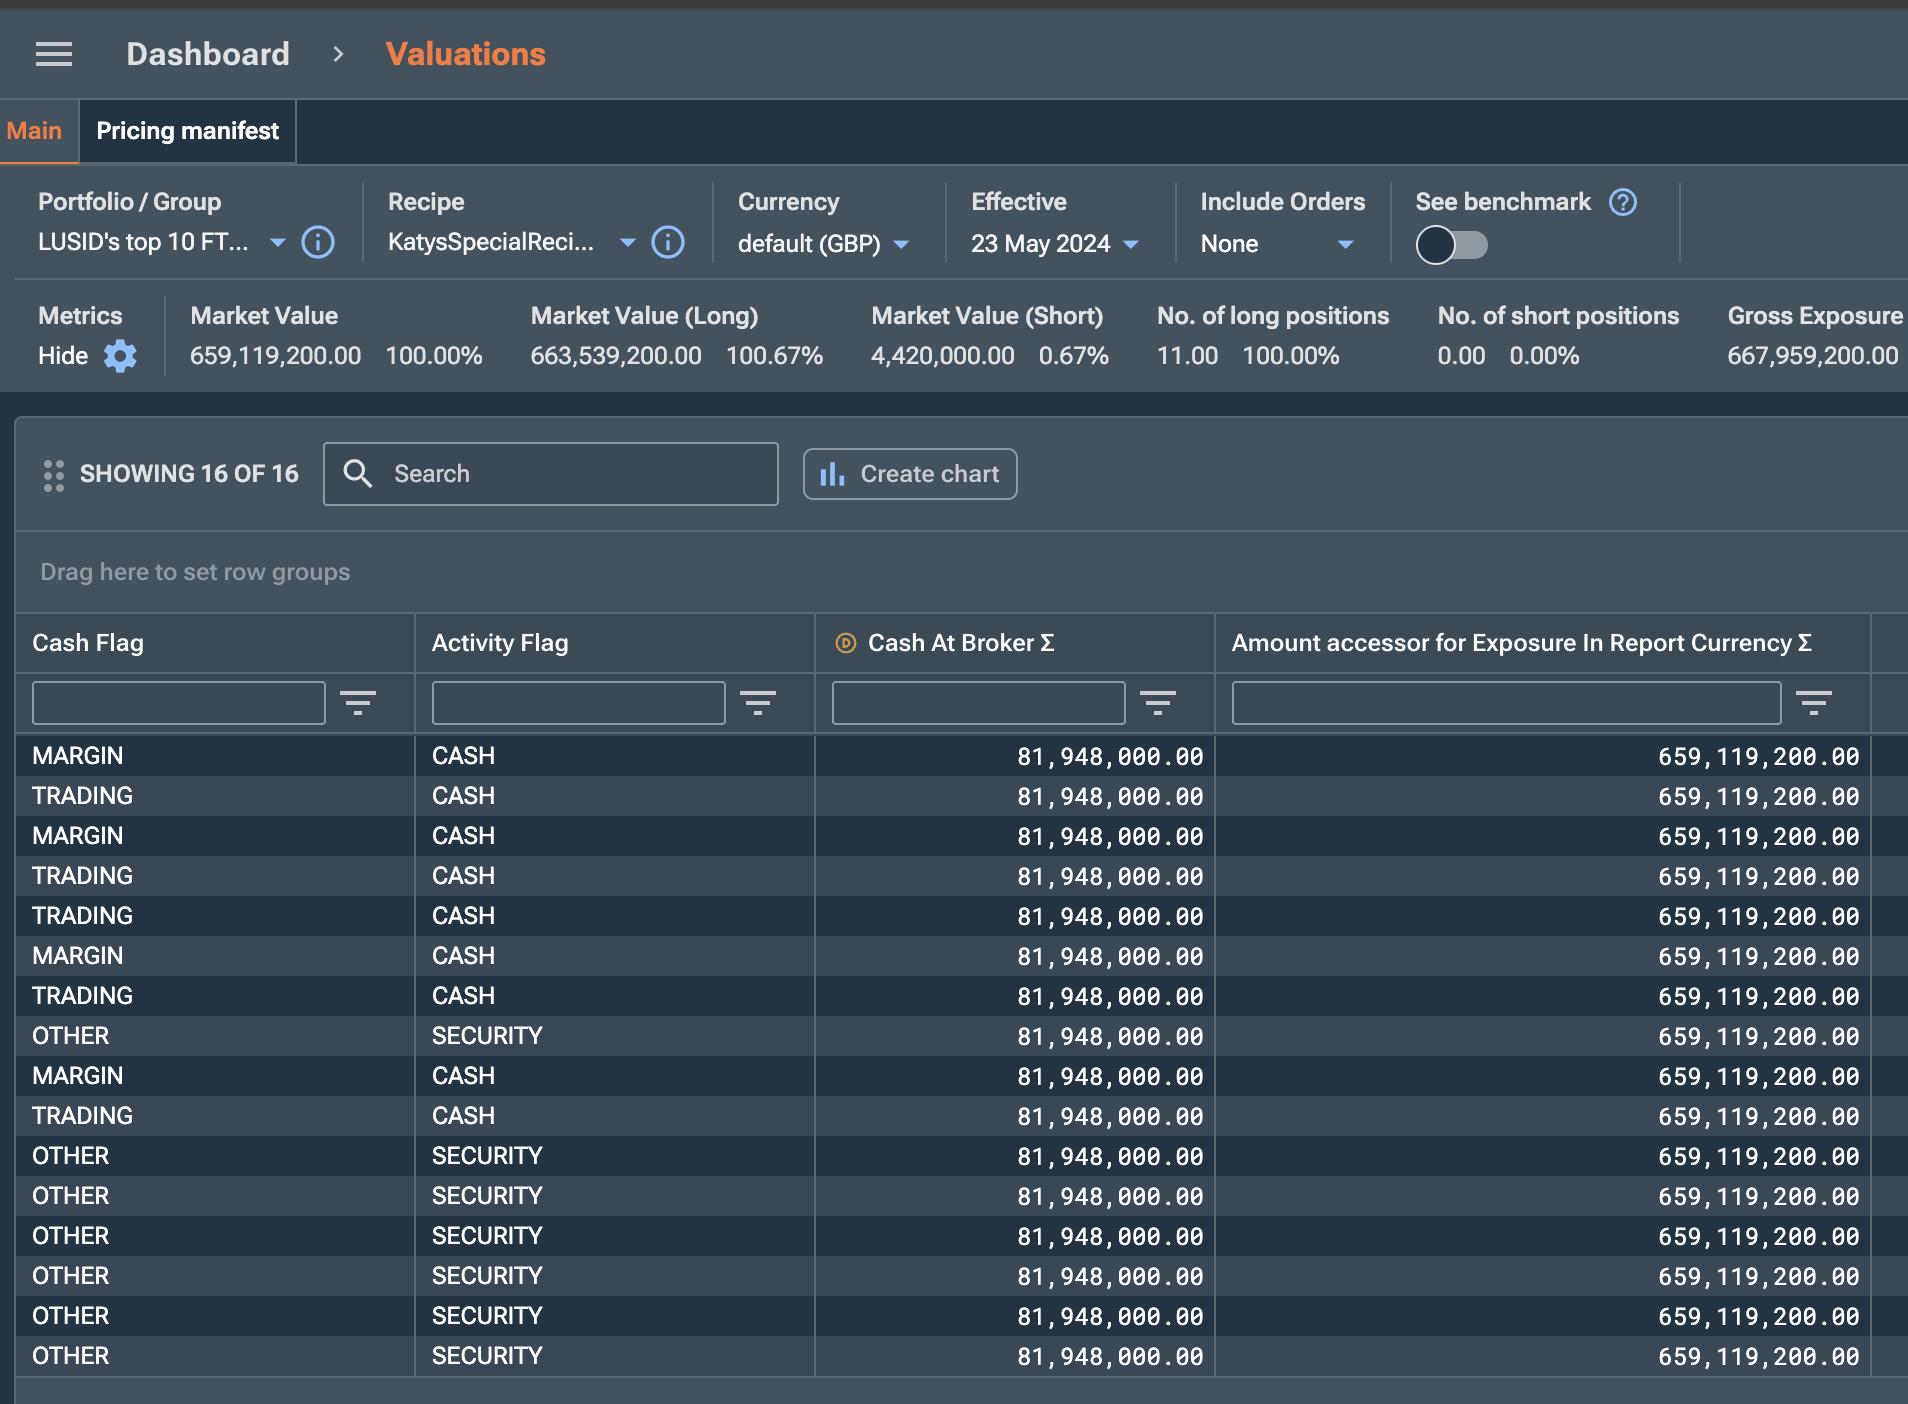

You can drag and drop the SHKs to see a more sensible view grouped by the SHKs, so Sum columns are now showing the summed values grouped by SHK, and we can see that the "Cash At Broker" property is correctly only populating with the exposure values when the CashFlag = MARGIN and ActivityFlag = CASH.

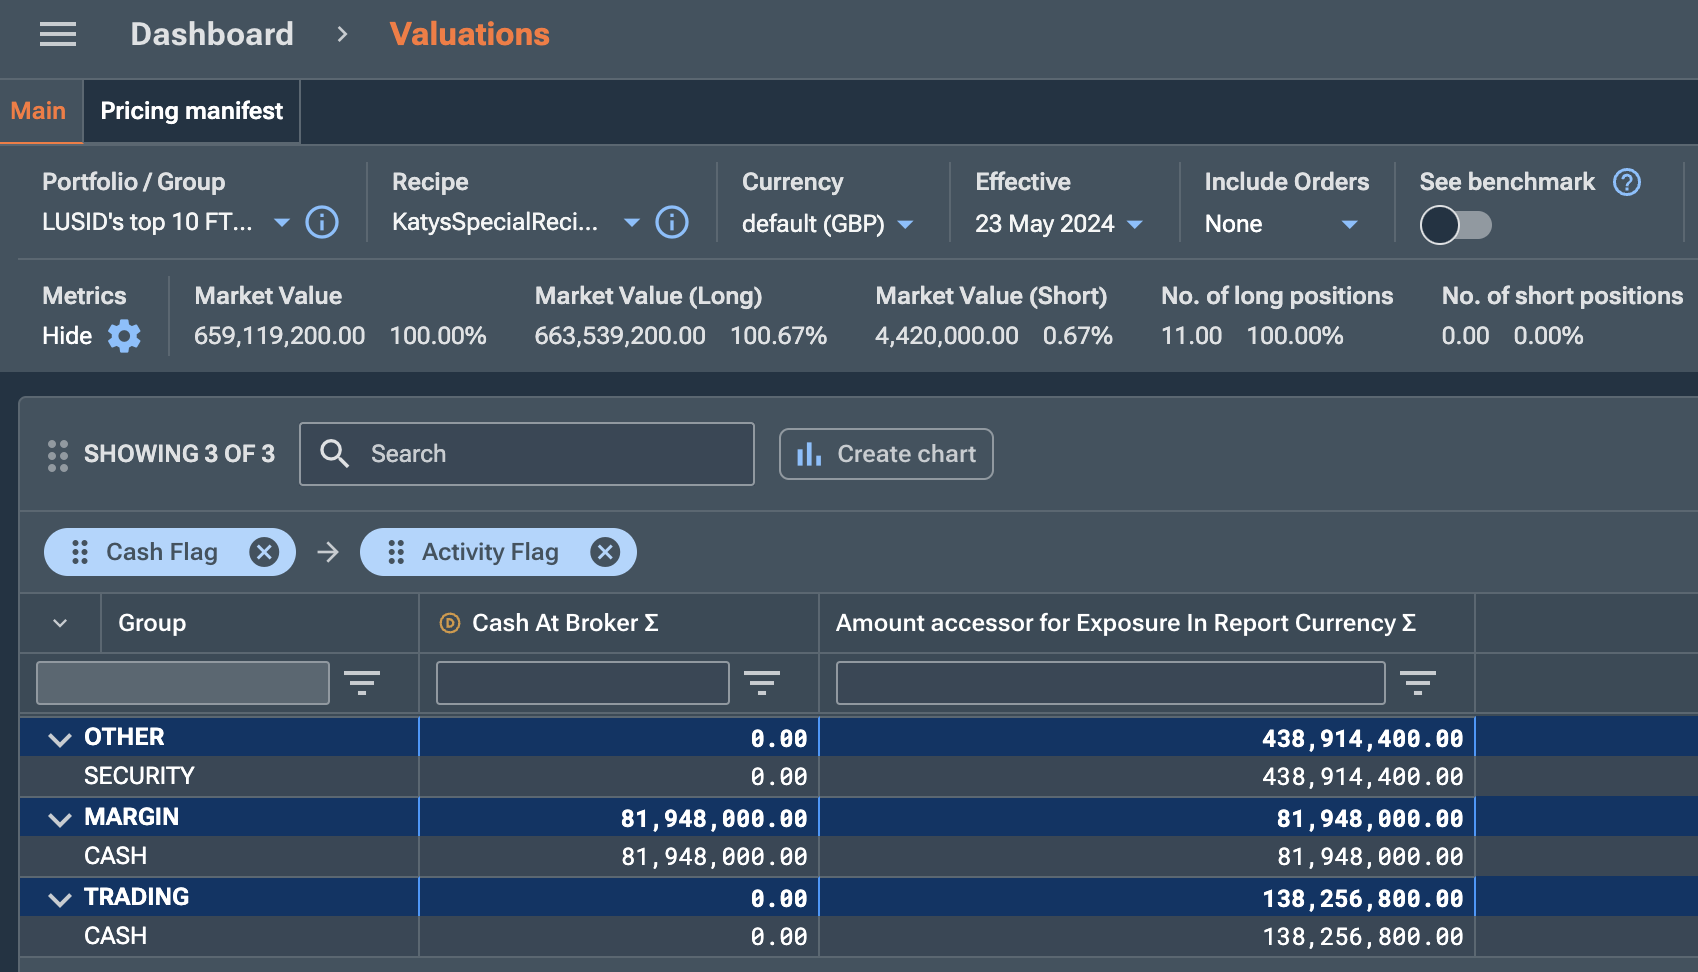

## Adding your derived valuation property to the rebalance dashboard

In your rebalance dashboard you can now add a column for your new "Cash At Broker" property with the sum operation into the top summary line of the dashboard:

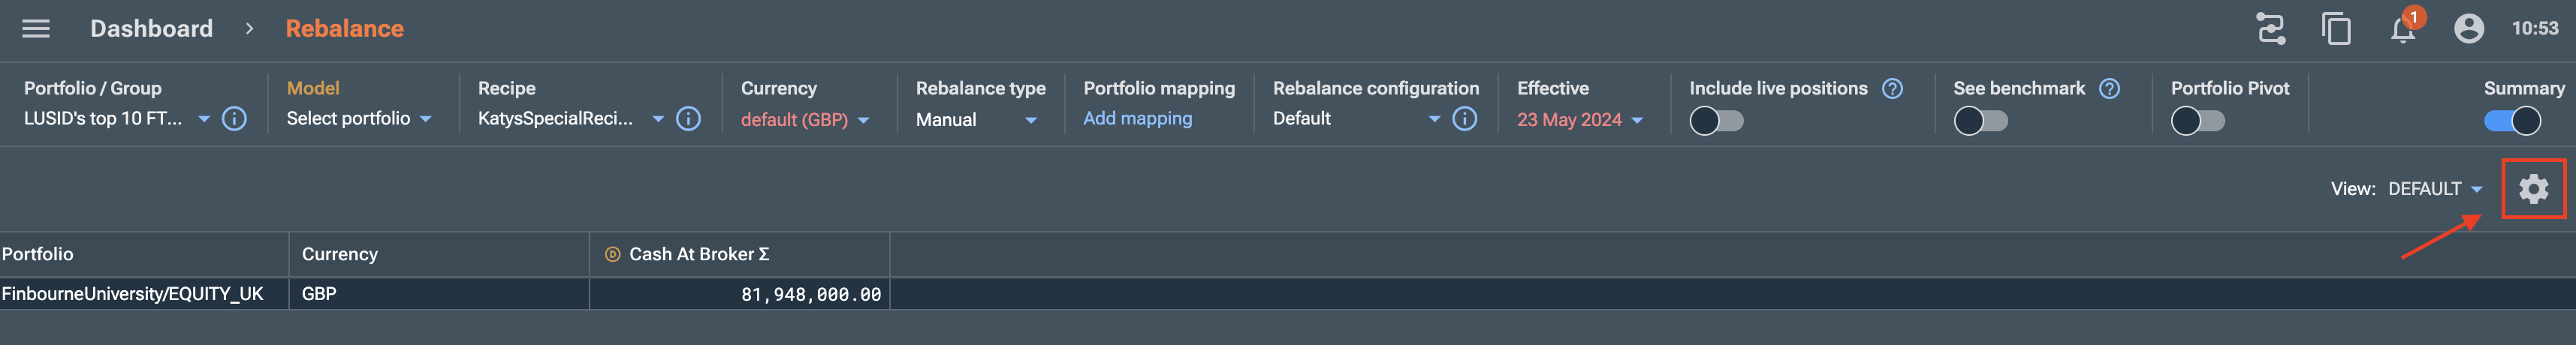

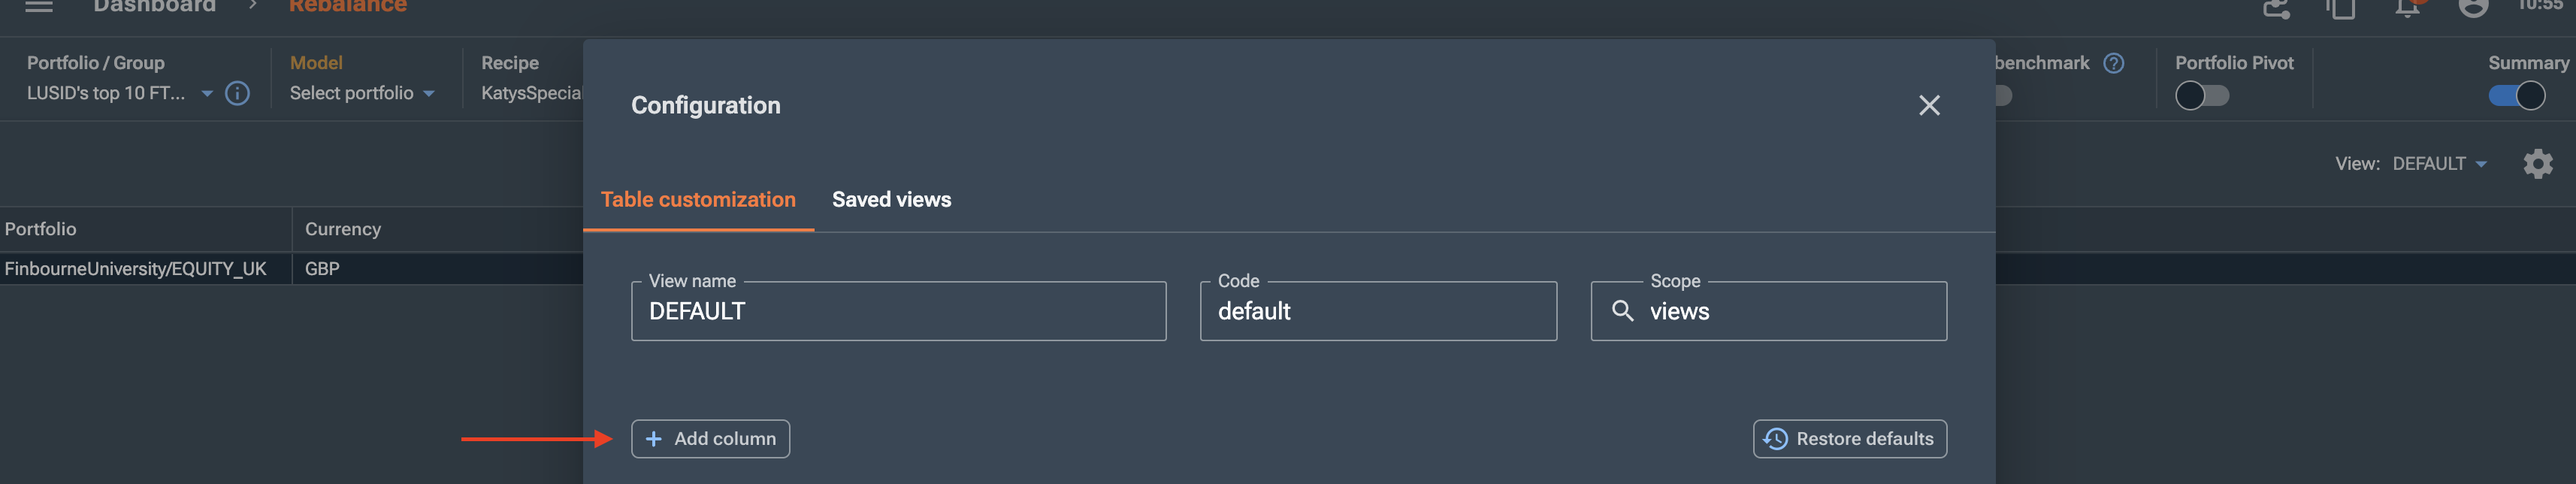

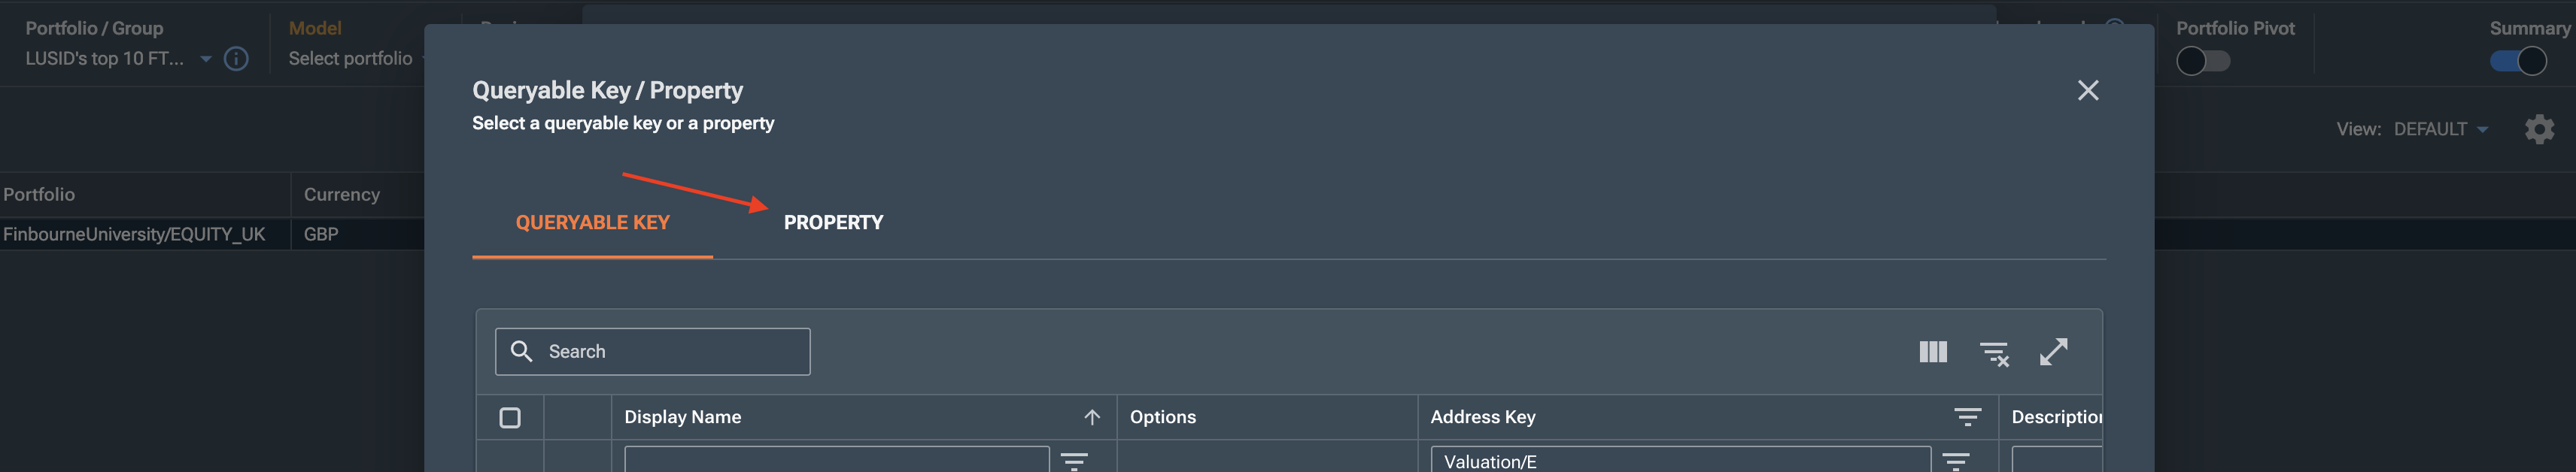

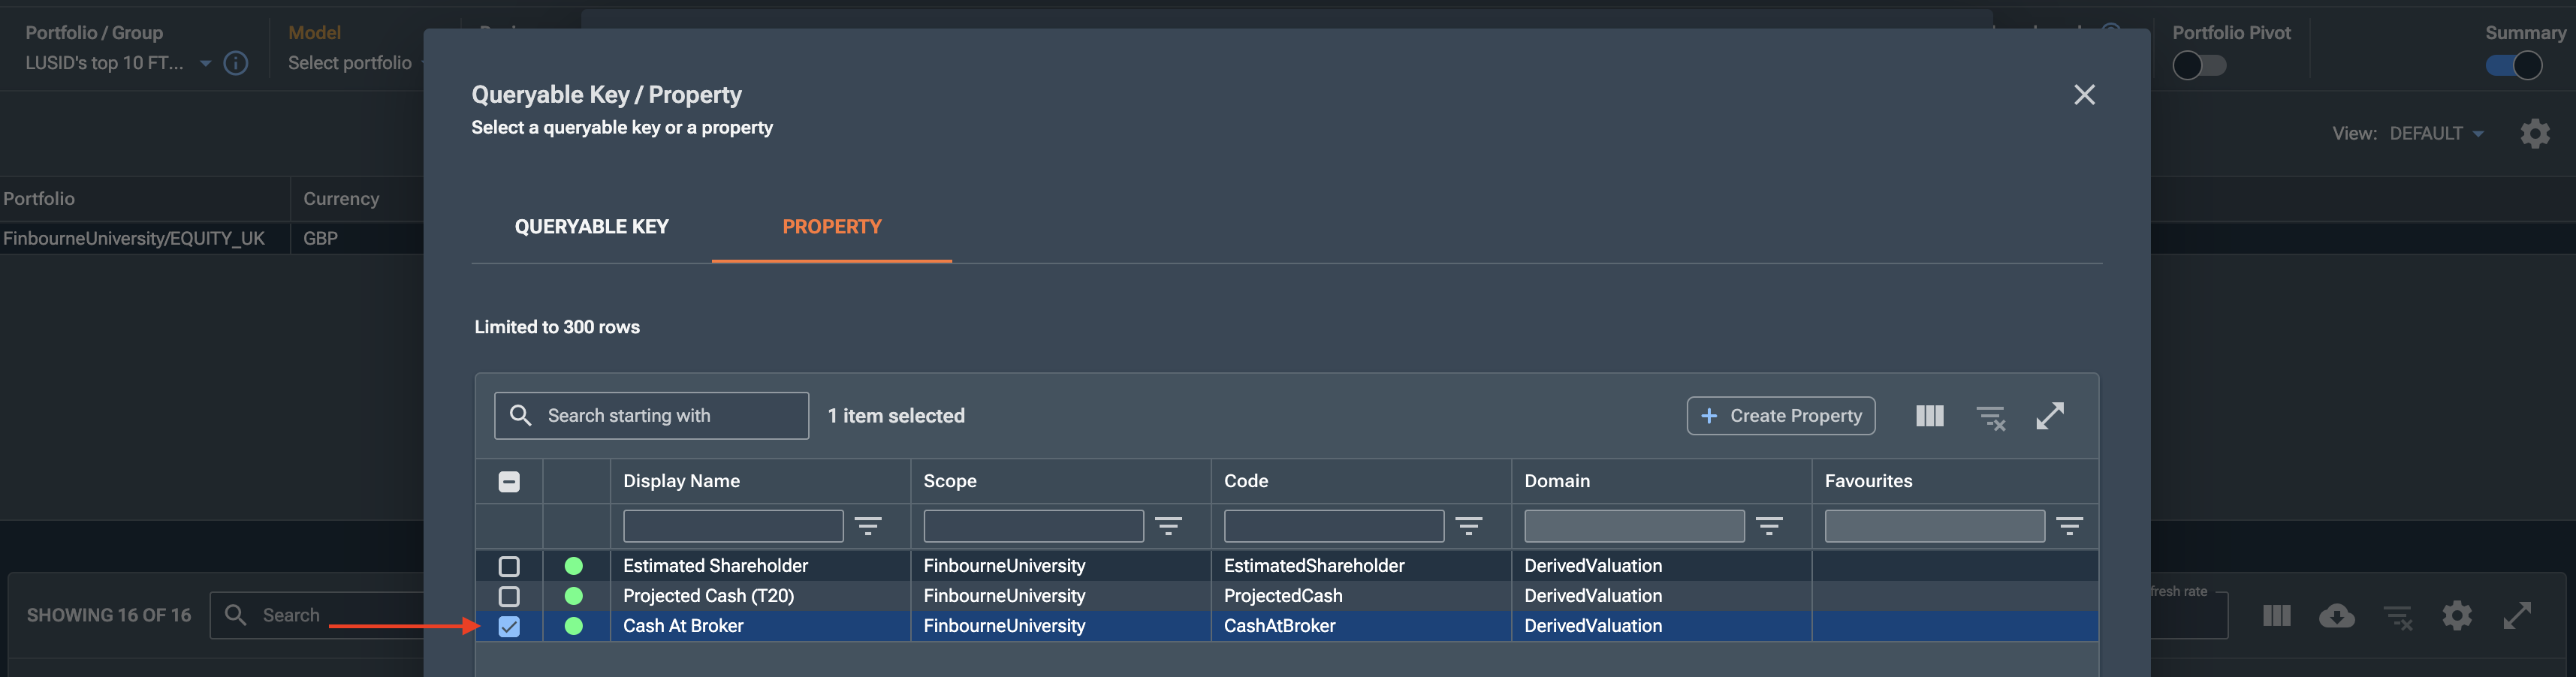

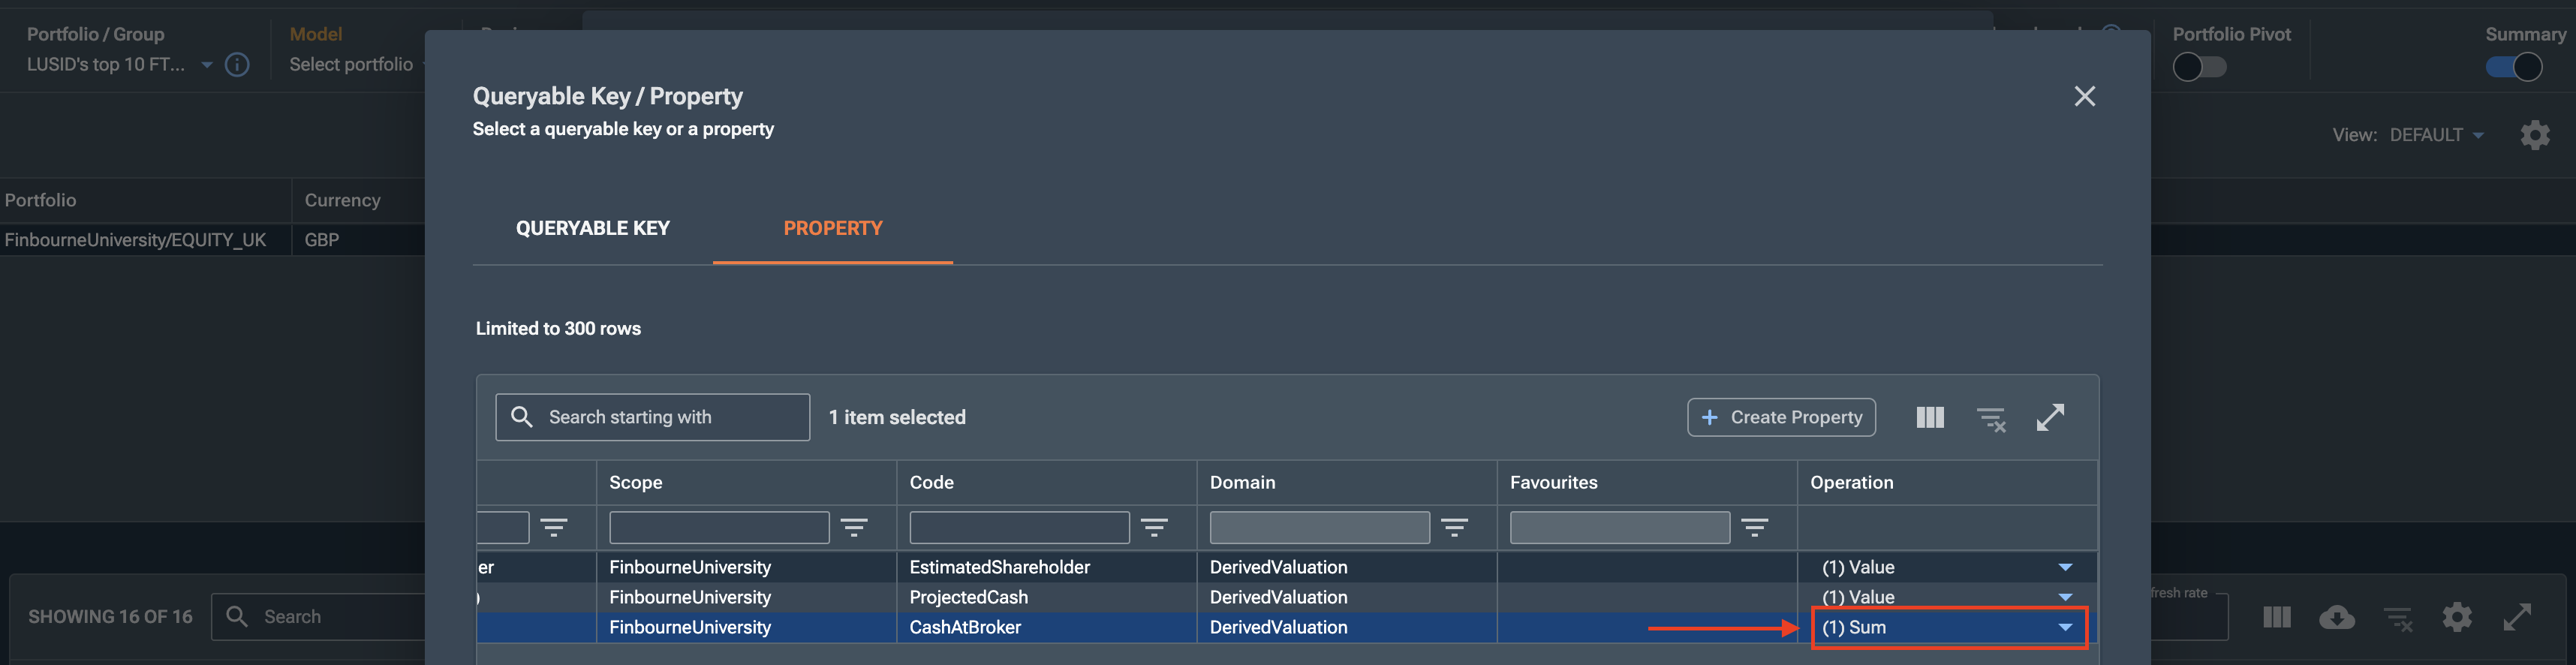

Submit and save, and you can now see a summary line for Cash At Broker in your rebalance dashboard:

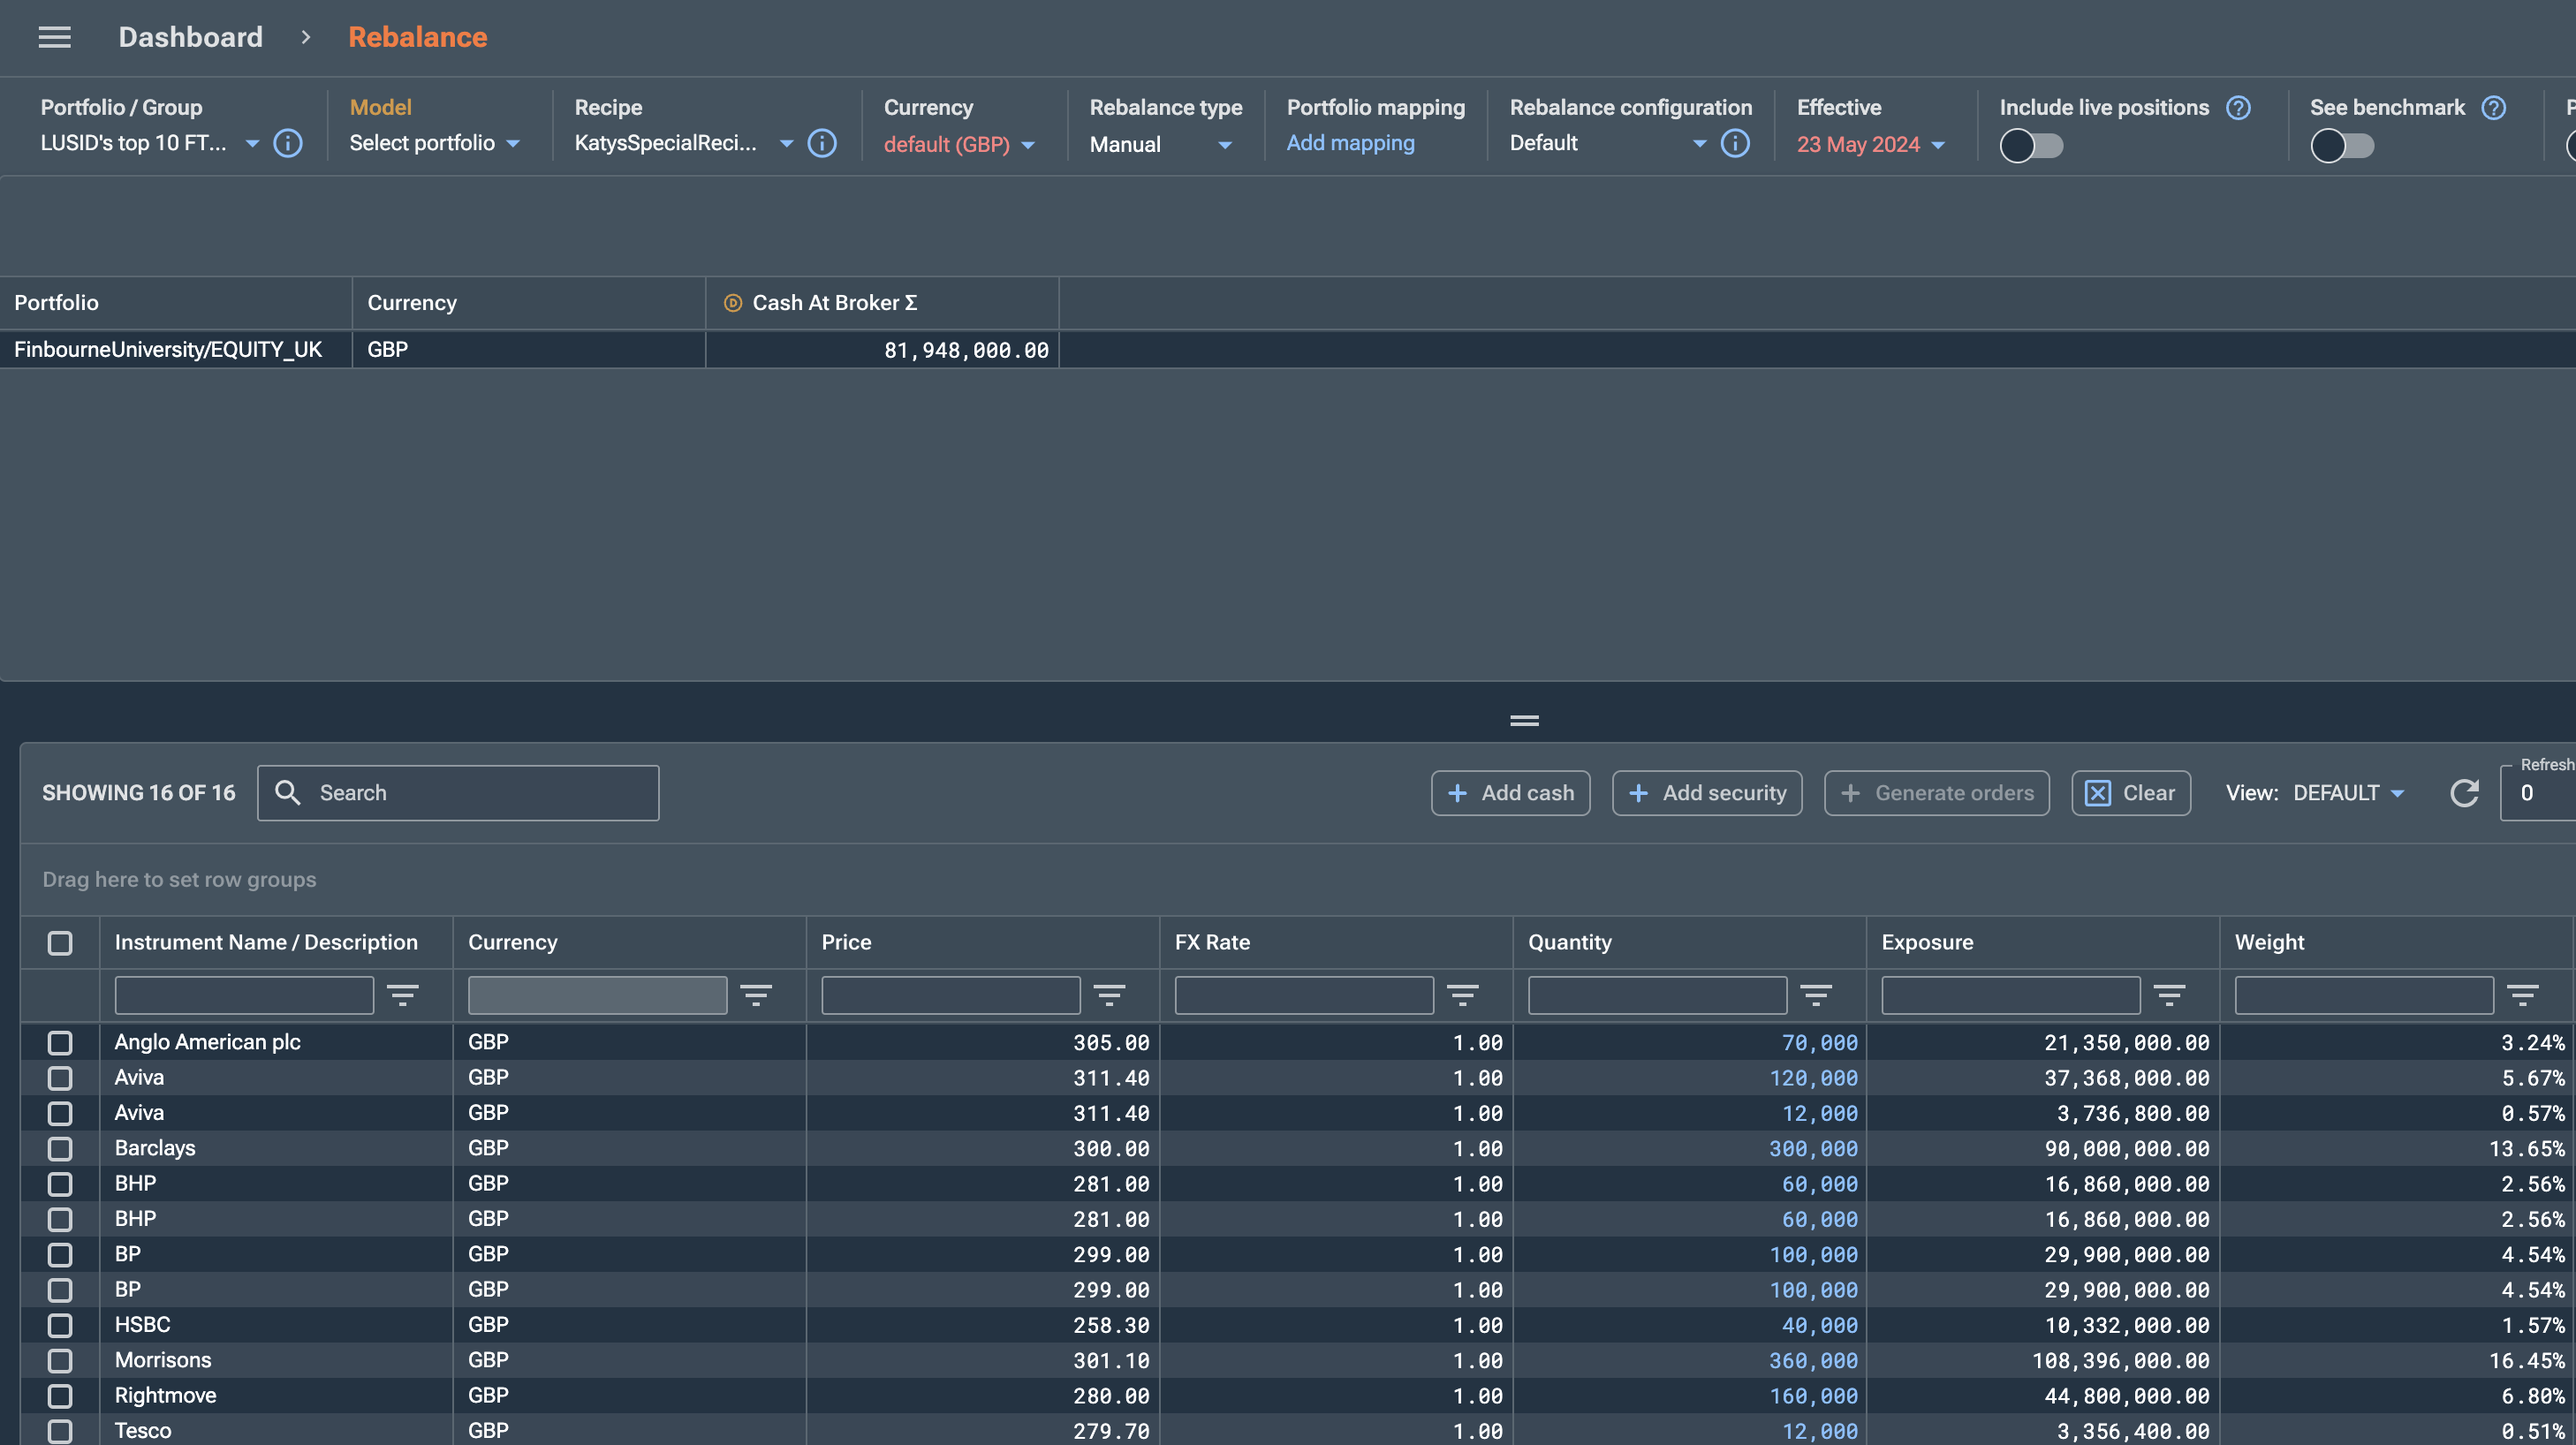

## Create a time variant portfolio property

..to represent the Total Net Assets

In [ ]:
create_property_definition_request = lm.CreatePropertyDefinitionRequest(
    domain,
    scope,
    code,
    data_type_id,
)

try:
    # CreatePropertyDefinition: Create property definition
    api_response = await property_api.create_property_definition(create_property_definition_request)
    pprint(api_response)
except ApiException as e:
    print("Exception when calling PropertyDefinitionsApi->create_property_definition: %s\n" % e)